# Contour Monte Carlo
This Julia notebook demonstrates how to perform Contour Monte Carlo to estimate cell population heterogeneity in a range of systems. Note that the code uses the `RCall` Julia package to call R, in order to use the vine copula kernel density estimation available in the R package `kdevine`.

In [1]:
using RCall, Compat, Random, Distributions, Plots, DifferentialEquations, LinearAlgebra, Plots, DelimitedFiles

R"library(kdevine)"
    
function f_solve(f_deriv, initial, tspan, parameters)
    prob = ODEProblem(f_deriv, initial, tspan, parameters)
    sol = solve(prob)
    return sol
end

function f_sample_solve_uniform(num_samples, population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial)
    n_params = size(bounds)[1]
    samples = zeros((num_samples, n_params))
    for i = 1:n_params
        samples[:, i] = rand(Uniform(bounds[i, 1], bounds[i, 2]), num_samples)
    end
    mOutputs = zeros((num_samples, length(population_sample)))
    for i in 1:num_samples
        sol = f_solve(f_deriv, initial, tspan, samples[i, :]);
        for j = 1:length(population_sample)
           mOutputs[i, j] = sol(times_solve[j], idxs=population_sample[j])
        end
    end
    return mOutputs
end

function f_sample_solve_uniform_uncertain_inits(num_samples, population_sample, times_solve,
        tspan, f_solve, f_deriv, bounds, nparams, ninits)
    n_params = size(bounds)[1]
    samples = zeros((num_samples, n_params))
    for i = 1:n_params
        samples[:, i] = rand(Uniform(bounds[i, 1], bounds[i, 2]), num_samples)
    end
    mOutputs = zeros((num_samples, length(population_sample)))
    for i in 1:num_samples
        sol = f_solve(f_deriv, samples[i, (nparams + 1):(nparams + ninits)], tspan, samples[i, 1:nparams]);
        for j = 1:length(population_sample)
           mOutputs[i, j] = sol(times_solve[j], idxs=population_sample[j])
        end
    end
    return mOutputs
end

function f_estimate_kdevine(mOutputs)
    @rput mOutputs
    R"fit <- kdevine(mOutputs)"
    R"saveRDS(fit, '../data/vine_fit.RDS')"
end

function dkdevine(params)
    @rput params
    R"z <- dkdevine(params, fit)"
    @rget z
    return z
end

function load_dkdevine_fit()
    R"z <- readRDS('../data/vine_fit.RDS')"
    @rget z
    return z
end

function f_step_bounds(vCurrent, bounds, sigma)
    vProposed = zeros(size(bounds)[1])
    for i = 1:length(vProposed)
        temp = (rand(Normal(vCurrent[i] - bounds[i, 1], sigma[i]), 1)[1] % (bounds[i, 2] - bounds[i, 1]))
        if temp < 0
            temp += bounds[i, 2]
        else
            temp += bounds[i, 1]
        end
        vProposed[i] = temp
    end
    return vProposed
end

function f_step_bounds_simple(vCurrent, bounds, sigma)
    vProposed = zeros(size(bounds)[1])
    for i = 1:length(vProposed)
        temp = rand(Normal(vCurrent[i], sigma[i]), 1)[1]
        vProposed[i] = temp
    end
    return vProposed
end

function f_mcmc_uniform_uncertain_ints(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, nparams, ninits)
    mInputs = zeros((num_samples, size(bounds)[1]))
    mOutputs = zeros((num_samples, length(population_sample)))
    vOutputs_temp = zeros(length(population_sample))
    vLogPDF = zeros(num_samples)
    vContour = zeros(num_samples)
    # initial points
    mInputs[1, :] = initial_inputs
    for j = 1:length(population_sample)
        sol = f_solve(f_deriv, mInputs[1, (nparams + 1):(nparams + ninits)], tspan, mInputs[1, 1:nparams]);
        mOutputs[1, j] = sol(times_solve[j], idxs=population_sample[j])
    end
    log_pdf_current = target_fn(mOutputs[1, :])
    log_contour_current = log(f_dkdevine(mOutputs[1, :]))
    # MCMC
    log_a = 0.0
    sigma = Matrix(Diagonal(sigma.^2))
    mu = initial_inputs
    for i = 2:num_samples
        if i <= (100 * (nparams + ninits))
            vProposed = rand(MvNormal(mInputs[i - 1, :], sigma), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, vProposed[(nparams + 1):(nparams + ninits)], tspan, vProposed[1:nparams]);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
        else
            s = i - (100 * (nparams + ninits))
            gamma = (s + 1)^(-0.6)
            vProposed = rand(MvNormal(mInputs[i - 1, :], Matrix(Hermitian(sigma)) * exp(log_a)), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, vProposed[(nparams + 1):(nparams + ninits)], tspan, vProposed[1:nparams]);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
            sigma = (1 - gamma) * sigma + gamma * (mInputs[i, :] - mu) * (mInputs[i, :] - mu)'
            mu = (1 - gamma) * mu + gamma * mInputs[i, :]
            log_a += gamma * (accepted - 0.25)
        end
    end
    return Dict("inputs" => mInputs, "outputs" => mOutputs, "log_pdf" => vLogPDF, "contour_volume" => vContour)
end

function f_mcmc_uniform(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial)
    mInputs = zeros((num_samples, size(bounds)[1]))
    mOutputs = zeros((num_samples, length(population_sample)))
    vOutputs_temp = zeros(length(population_sample))
    vLogPDF = zeros(num_samples)
    vContour = zeros(num_samples)
    # initial points
    mInputs[1, :] = initial_inputs
    for j = 1:length(population_sample)
        sol = f_solve(f_deriv, initial, tspan, mInputs[1, :]);
        mOutputs[1, j] = sol(times_solve[j], idxs=population_sample[j])
    end
    log_pdf_current = target_fn(mOutputs[1, :])
    log_contour_current = log(f_dkdevine(mOutputs[1, :]))
    # MCMC
    log_a = 0.0
    sigma = Matrix(Diagonal(sigma.^2))
    mu = initial_inputs
    for i = 2:num_samples
        if i <= (100 * length(initial_inputs))
            vProposed = rand(MvNormal(mInputs[i - 1, :], sigma), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, initial, tspan, vProposed);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
        else
            s = i - (100 * length(initial_inputs))
            gamma = (s + 1)^(-0.6)
            vProposed = rand(MvNormal(mInputs[i - 1, :], Matrix(Hermitian(sigma)) * exp(log_a)), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, initial, tspan, vProposed);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
            sigma = (1 - gamma) * sigma + gamma * (mInputs[i, :] - mu) * (mInputs[i, :] - mu)'
            mu = (1 - gamma) * mu + gamma * mInputs[i, :]
            log_a += gamma * (accepted - 0.25)
        end
    end
    return Dict("inputs" => mInputs, "outputs" => mOutputs, "log_pdf" => vLogPDF, "contour_volume" => vContour)
end

function f_log_pdf(v_values, v_dist)
    log_pdf = 0.0
    k = 1
    for val in v_values
        log_pdf += logpdf(v_dist[k], val)
        k += 1
    end
    return log_pdf
    end

function f_mcmc_uniform_multiple(nchains, num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial)
    vResults = []
    for i = 1:nchains
         push!(vResults, f_mcmc_uniform(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial))
    end
    return vResults
end

function f_mcmc_uniform_uncertain_ints_multiple(nchains, num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, nparams, ninits)
    vResults = []
    for i = 1:nchains
         push!(vResults, f_mcmc_uniform_uncertain_ints(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, nparams, ninits))
    end
    return vResults
end

function f_between(vResults)
    nchains = length(vResults)
    inputs = vResults[1]["inputs"];
    nparams = size(inputs)[2];
    mMeans = zeros((nchains, nparams));
    for i = 1:nchains
        inputs = vResults[i]["inputs"];
        for j = 1:nparams
            mMeans[i, j] = mean(inputs[:, j]);
        end
    end
    t = size(inputs)[1];
    vOverallMean = mean(mMeans, dims=1);
    vVar = (t / (nchains - 1)) * sum((mMeans .- vOverallMean).^2, dims=1);
    return vVar
end

function f_within(vResults)
    nchains = length(vResults)
    inputs = vResults[1]["inputs"];
    nparams = size(inputs)[2];
    mVars = zeros((nchains, nparams));
    for i = 1:nchains
        inputs = vResults[i]["inputs"];
        for j = 1:nparams
            mVars[i, j] = var(inputs[:, j]);
        end
    end
    return mean(mVars, dims=1)
end

function f_rhat(vResults)
    nchains = length(vResults)
    inputs = vResults[1]["inputs"];
    nparams = size(inputs)[2];
    t = size(inputs)[1];
    vWithin = f_within(vResults);
    vBetween = f_between(vResults);
    return sqrt.((vBetween ./ t + vWithin) ./ vWithin)
end


R version 3.4.2 (2017-09-28) -- "Short Summer"
Copyright (C) 2017 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.



┌ Warning: RCall.jl: Warning: package 'kdevine' was built under R version 3.4.4
│ The kdevine package is no longer actively developed. Consider using 
│    - the 'kde1d' package for marginal estimation, 
│    - the functions vine() and vinecop() from the 'rvinecopulib' 
│      package as replacements for kdevine() and kdevincop().
└ @ RCall C:\Users\bclamber\.julia\packages\RCall\ffM0W\src\io.jl:113


f_rhat (generic function with 1 method)

## Michaelis-Menten kinetics
### Targeting a bimodal target
First estimate volume of contours.

In [2]:
function deriv_michaelis_menten(dydt, y, p, t)
    k_f = p[1]
    k_r = p[2]
    k_cat = p[3]
    dydt[1] = -k_f * y[1] * y[2] + k_r * y[3] + k_cat * y[3]
    dydt[2] = -k_f * y[1] * y[2] + k_r * y[3]
    dydt[3] = k_f * y[1] * y[2] - k_r * y[3] - k_cat * y[3]
    dydt[4] = k_cat * y[3]
end

# number of independent samples to take from bounds
ncontourvolsteps = 100000

# bounds of parameters (uniform prior within bounds assumed)
mBounds = [[0.2 15]; [0.2 2]; [0.5 3]];

tspan = (0.0, 10.0)
initial_states = [4.0; 8.0; 0.0; 0.0];
populations_observed = [1, 2]
times_observed = [2, 1]

mOutputs = @time f_sample_solve_uniform(ncontourvolsteps, populations_observed, times_observed,
    tspan, f_solve, deriv_michaelis_menten, mBounds, initial_states);

@time f_estimate_kdevine(mOutputs);

 39.545460 seconds (163.33 M allocations: 12.626 GiB, 6.61% gc time)
660.183233 seconds (222.17 k allocations: 11.293 MiB)


Target distribution.

In [3]:
function f_michaelis_menten_bimodal(v_values)
    dist_1 = MixtureModel(MvNormal[MvNormal([2.15, 1.6], [[0.0184 -0.013]; [-0.013 0.01]]),
                          MvNormal([2.8, 1.0], [[0.02 -0.01]; [-0.01 0.02]])])
    return logpdf(dist_1, v_values)
end

f_michaelis_menten_bimodal (generic function with 1 method)

Doing MCMC.

In [4]:
# number of chains (not run in parallel due to RCall)
nchains = 4
# number of MCMC steps (adapting after 100 * length(initial_parametesr))
nsamples = 10000
# MCMC initial (before adaptation) step sizes
sigma = [1, 0.1, 0.1]
# initial parameters
initial_parameters = [2.5; 0.5; 0.5]

vResults = @time f_mcmc_uniform_multiple(nchains, nsamples, f_michaelis_menten_bimodal, dkdevine,
                    sigma, populations_observed, times_observed, tspan,
                    f_solve, deriv_michaelis_menten,
                    mBounds, initial_parameters, initial_states);

1293.564831 seconds (60.60 M allocations: 4.568 GiB, 0.09% gc time)


In [5]:
function output_samples(vResults, name)
    mInputs = []
    mOutputs = []
    for i = 1:length(vResults)
        temp = vResults[i]["inputs"]
        temp_outputs = vResults[i]["outputs"]
        if i == 1
            mInputs = temp
            mOutputs = temp_outputs
        else
            mInputs = vcat(mInputs, temp)
            mOutputs = vcat(mOutputs, temp_outputs)
        end
    end
    writedlm(string("../data/", name, "_inputs.csv"), mInputs, ',')
    writedlm(string("../data/", name, "_outputs.csv"), mOutputs, ',')
end
output_samples(vResults, "mm_bimodal")

Check convergence diagnostics.

In [6]:
f_rhat(vResults)

1×3 Array{Float64,2}:
 1.00059  1.00206  1.01059

Plot trace of first parameter.

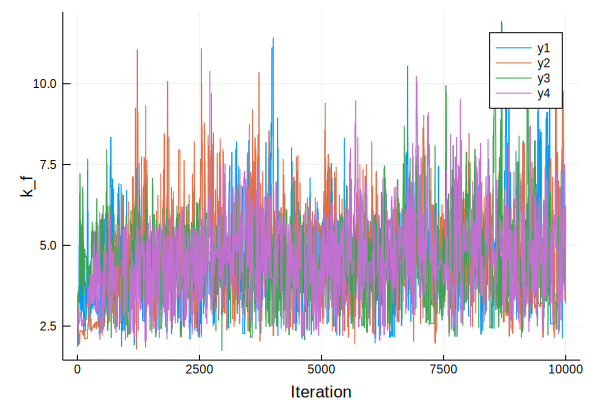

In [7]:
plot(vResults[1]["inputs"][:, 1])
plot!(vResults[2]["inputs"][:, 1])
plot!(vResults[3]["inputs"][:, 1])
plot!(vResults[4]["inputs"][:, 1])
xlabel!("Iteration")
ylabel!("k_f")

Plot first output for all chains.

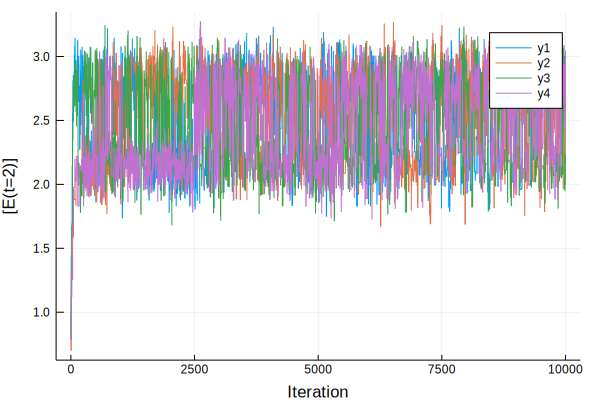

In [8]:
plot(vResults[1]["outputs"][:, 1])
plot!(vResults[2]["outputs"][:, 1])
plot!(vResults[3]["outputs"][:, 1])
plot!(vResults[4]["outputs"][:, 1])
xlabel!("Iteration")
ylabel!("[E(t=2)]")

Plot two dimensional outputs for a single chain.

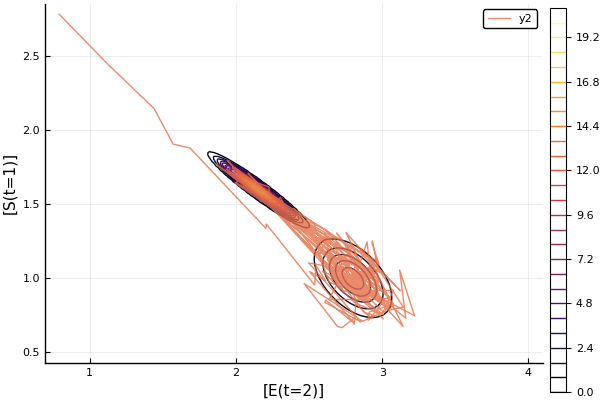

C:\Users\bclamber\.julia\conda\3\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)


In [9]:
noutputs = 1000

pyplot()
dist = MixtureModel(MvNormal[MvNormal([2.15, 1.6], [[0.0184 -0.013]; [-0.013 0.01]]),
                          MvNormal([2.8, 1.0], [[0.02 -0.01]; [-0.01 0.02]])])
V(x,y) = pdf(dist, [x, y])
x = range(1, 4, length=100)
y = range(0.5, 2, length=100)
contour(x, y, (x,y)->V(x,y), levels=30)
plot!(vResults[1]["outputs"][1:noutputs, 1], vResults[1]["outputs"][1:noutputs, 2], alpha=0.8)
xlabel!("[E(t=2)]")
ylabel!("[S(t=1)]")

### Targeting a 4 dimensional output distribution

In [10]:
# number of independent samples to take from bounds
ncontourvolsteps = 200000

mBounds = [[0.2 15]; [0.2 2]; [0.2 3]; [3 5]; [5 10]; [0 0.2]; [0 0.2]];
tspan = (0.0, 10.0)
populations_observed = [1, 2, 1, 2]
times_observed = [1, 1, 2, 2]
nparams = 3
ninit_params = 4

mOutputs = @time f_sample_solve_uniform_uncertain_inits(ncontourvolsteps, populations_observed, times_observed, tspan, f_solve,
    deriv_michaelis_menten, mBounds, nparams, ninit_params);

@time f_estimate_kdevine(mOutputs);

 60.383470 seconds (266.55 M allocations: 21.340 GiB, 7.85% gc time)
5845.599182 seconds (103.00 k allocations: 5.220 MiB)


Do MCMC.

In [11]:
nchains = 4
nsamples = 10000

dist = MvNormal([0.5, 2.8, 0.9, 1.4],
       [[0.015  -0.05   0.04  -0.05];
        [-0.05   0.30   -0.15 0.20];
        [0.04  -0.15    0.12    -0.17]; 
        [-0.05   0.2   -0.17    0.3]])
sigma = [1, 0.2, 0.1, 0.25, 0.25, 0.01, 0.01]
initial_parameters = [5, 1.5, 0.5, 4, 8, 0.05, 0.05]

vResults = @time f_mcmc_uniform_uncertain_ints_multiple(nchains, nsamples, x -> logpdf(dist, x), dkdevine, sigma,
    populations_observed, times_observed,
    tspan, f_solve, deriv_michaelis_menten,
    mBounds, initial_parameters, nparams, ninit_params);
output_samples(vResults, "mm_4d")

3207.237750 seconds (27.88 M allocations: 2.446 GiB, 0.02% gc time)


Check convergence diagnostics.

In [12]:
f_rhat(vResults)

1×7 Array{Float64,2}:
 1.01823  1.01216  1.00916  1.01853  1.01024  1.01605  1.00942

Plot a sample of outputs versus target.

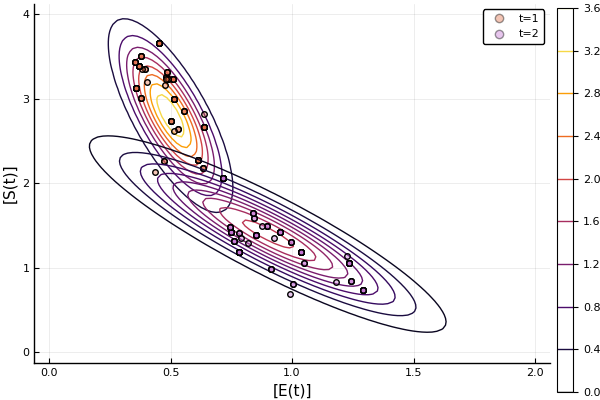

In [13]:
pyplot()
amin = 1
amax = 100
temp = vResults[1]
mu = mean(dist)
sigma = cov(dist)
dist1 = MvNormal(mu[1:2], sigma[1:2, 1:2])
V(x,y) = pdf(dist1, [x, y])
x = range(0, 2, length=100)
y = range(0, 4, length=100)
contour(x, y, (x,y)->V(x,y), levels=10, color="black")
scatter!(temp["outputs"][amin:amax, 1], temp["outputs"][amin:amax, 2], alpha=0.4, label="t=1")
dist2 = MvNormal(mu[3:4], sigma[3:4, 3:4])
V(x,y) = pdf(dist2, [x, y])
contour!(x, y, (x,y)->V(x,y), levels=10, color="black")
scatter!(temp["outputs"][amin:amax, 3], temp["outputs"][amin:amax, 4], alpha=0.4, label="t=2")
xlabel!("[E(t)]")
ylabel!("[S(t)]")

## TNF signalling pathway

In [14]:
function inh(x, b)
    return b^2 / (x^2 + b^2)
end

function act(x, a)
    return x^2 / (a^2 + x^2)
end

function u(t)
    if t < 2
        return 1.0
    else
        return 0.0
    end
end

function deriv_tnf_signalling(dxdt, y, p, t)
    a1=p[1]; a2=p[2]; a3=p[3]; a4=p[4];
    b1=p[5]; b2=p[6]; b3=p[7]; b4=p[8]; b5=p[9];
    x1=y[1]; x2=y[2]; x3=y[3]; x4=y[4];
    dxdt[1] = -x1 + 0.5 * (inh(x3, b4) * act(u(t), a1) + act(x2, a3))
    dxdt[2] = -x2 + act(x1, a2) * inh(x3, b3)
    dxdt[3] = -x3 + inh(x2, b2) * inh(x4, b5)
    dxdt[4] = -x4 + 0.5 * (inh(u(t), b1) + act(x3, a4))
end

deriv_tnf_signalling (generic function with 1 method)

In [15]:
ncontourvolsamples = 50000
mBounds = [[0.5 0.7]; [0.1 0.3]; [0.1 0.3]; [0.4 0.6]; [0.3 0.5]; [0.6 0.8]; [0.2 0.4]; [0.4 0.6]; [0.3 0.5]];


tspan = (0.0, 11.0)
initial = [0.0; 0.0; 0.29; 0.625];
populations_observed = [2, 2, 2]
times_observed = [1, 2, 4]

mOutputs = @time f_sample_solve_uniform(ncontourvolsamples, populations_observed, times_observed,
    tspan, f_solve, deriv_tnf_signalling,
    mBounds, initial);

@time f_estimate_kdevine(mOutputs);

@time load_dkdevine_fit();

 13.393506 seconds (49.82 M allocations: 3.500 GiB, 7.54% gc time)
372.663694 seconds (112 allocations: 3.453 KiB)
  0.574838 seconds (1.54 M allocations: 103.708 MiB, 4.97% gc time)


In [16]:
function f_tnf_bimodal(v_values)
    dist_1 = Normal(0.0625, 0.01);
    dist_2 = MixtureModel([Normal(0.10, 0.01), Normal(0.14, 0.01)]);
    dist_4 = MixtureModel([Normal(0.10, 0.01), Normal(0.2, 0.01)]);
    return f_log_pdf(v_values, [dist_1, dist_2, dist_4])
end

nchains = 4
nsamples = 10000
initial_parameters = [0.6, 0.2, 0.2, 0.5, 0.4, 0.7, 0.3, 0.5, 0.4];
sigma = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

vResults = @time f_mcmc_uniform_multiple(nchains, nsamples, f_tnf_bimodal, dkdevine,
    sigma, populations_observed, times_observed, tspan, f_solve,
    deriv_tnf_signalling, mBounds, initial_parameters, initial);
output_samples(vResults, "tnf_bimodal")

626.739003 seconds (29.09 M allocations: 2.191 GiB, 0.12% gc time)


Check convergence diagnostics.

In [17]:
println(f_rhat(vResults))

[1.0582 1.35617 1.06851 1.04557 1.2093 1.04428 1.2936 1.01554 1.14996]


Plot output distribution.

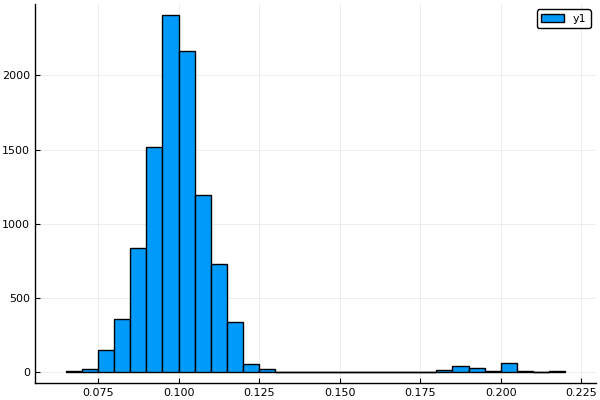

In [18]:
temp = vResults[1]
histogram(temp["outputs"][:, 3], bins=40)

## Growth factor model (Dixit, 2018)

### Using uniform priors

In [19]:
function deriv_growth_factor(dxdt, y, p, t)
    RT=p[1]; kdegstar=p[2]; k1=p[3];
    kminus1=p[4]; kdeg=p[5]; L=p[6]; 
    R=y[1]; P=y[2];
    kdel = RT * kdeg;
    dxdt[1] = kdel - k1 * L * R + kminus1 * P - kdeg * R;
    dxdt[2] = k1 * L * R - kminus1 * P - kdegstar * P
end

# number of independent samples to take from bounds
ncontourvolsteps = 100000

# bounds of parameters (uniform prior within bounds assumed)
mBounds = [[2.5 * 10^5 8 * 10^5]; [0.1 0.5]; [0.25 3]; [2 20]; [0.005 0.03]];

tspan = (0.0, 20.0)
initial_states = [0.0; 0.0];
populations_observed = [2, 2]
times_observed = [10, 10]

function f_sample_solve_uniform_growth_factor(num_samples, population_sample, times_solve,
        tspan, f_solve, f_deriv, bounds, initial)
    n_params = size(bounds)[1]
    samples = zeros((num_samples, n_params))
    vL = [2, 10]
    for i = 1:n_params
        samples[:, i] = rand(Uniform(bounds[i, 1], bounds[i, 2]), num_samples)
    end
    mOutputs = zeros((num_samples, length(population_sample)))
    for i in 1:num_samples
        for j = 1:length(population_sample)
            sol = f_solve(f_deriv, initial, tspan, vcat(samples[i, :], [vL[j]]));
            mOutputs[i, j] = sol(times_solve[j], idxs=population_sample[j])
        end
    end
    return mOutputs
end

mOutputs = @time f_sample_solve_uniform_growth_factor(ncontourvolsteps, populations_observed, times_observed,
    tspan, f_solve, deriv_growth_factor, mBounds, initial_states);

@time f_estimate_kdevine(mOutputs);

 50.160933 seconds (197.15 M allocations: 14.389 GiB, 7.82% gc time)
678.183650 seconds (112 allocations: 3.453 KiB)


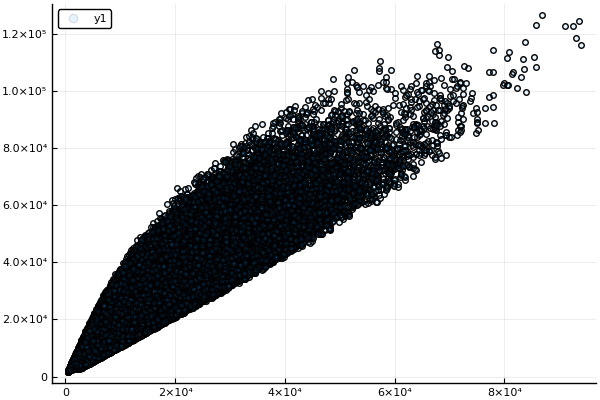

In [20]:
scatter(mOutputs[:, 1], mOutputs[:, 2], alpha=0.1)

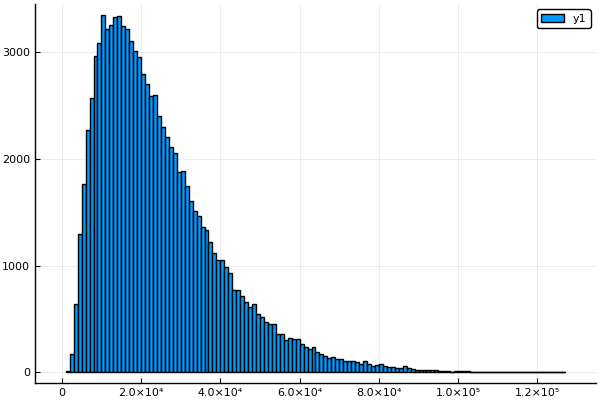

In [21]:
histogram(mOutputs[:, 2])

In [22]:
function f_mcmc_uniform_growth_factor(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial)
    mInputs = zeros((num_samples, size(bounds)[1]))
    mOutputs = zeros((num_samples, length(population_sample)))
    vOutputs_temp = zeros(length(population_sample))
    vLogPDF = zeros(num_samples)
    vContour = zeros(num_samples)
    vL = [2, 10]
    # initial points
    mInputs[1, :] = initial_inputs
    for j = 1:length(population_sample)
        sol = f_solve(f_deriv, initial, tspan, vcat(mInputs[1, :], [vL[j]]));
        mOutputs[1, j] = sol(times_solve[j], idxs=population_sample[j])
    end
    log_pdf_current = target_fn(mOutputs[1, :])
    log_contour_current = log(f_dkdevine(mOutputs[1, :]))
    # MCMC
    log_a = 0.0
    sigma = Matrix(Diagonal(sigma.^2))
    mu = initial_inputs
    for i = 2:num_samples
        if i <= (100 * length(initial_inputs))
            vProposed = rand(MvNormal(mInputs[i - 1, :], sigma), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                for j = 1:length(population_sample)
                    sol = f_solve(f_deriv, initial, tspan, vcat(vProposed, [vL[j]]));
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -30)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
        else
            s = i - (100 * length(initial_inputs))
            gamma = (s + 1)^(-0.6)
            vProposed = rand(MvNormal(mInputs[i - 1, :], Matrix(Hermitian(sigma)) * exp(log_a)), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                for j = 1:length(population_sample)
                    sol = f_solve(f_deriv, initial, tspan, vcat(vProposed, [vL[j]]));
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -30)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
            sigma = (1 - gamma) * sigma + gamma * (mInputs[i, :] - mu) * (mInputs[i, :] - mu)'
            mu = (1 - gamma) * mu + gamma * mInputs[i, :]
            log_a += gamma * (accepted - 0.25)
        end
    end
    return Dict("inputs" => mInputs, "outputs" => mOutputs, "log_pdf" => vLogPDF, "contour_volume" => vContour)
end

function f_mcmc_uniform_growth_factor_multiple(nchains, num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial)
    vResults = []
    for i = 1:nchains
         push!(vResults, f_mcmc_uniform_growth_factor(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial))
    end
    return vResults
end

f_mcmc_uniform_growth_factor_multiple (generic function with 1 method)

In [23]:
# number of chains (not run in parallel due to RCall)
nchains = 4
# number of MCMC steps (adapting after 100 * length(initial_parametesr))
nsamples = 10000
# MCMC initial (before adaptation) step sizes
sigma = [1.0 * 10^5, 0.05, 0.025, 0.5, 0.0005];
# initial parameters
initial_parameters = [4.0 * 10^5; 0.25; 1.0; 10; 0.01]
dist = MvNormal([2.0 * 10^4, 3.0 * 10^4], [[100000.0 0.0]; [0.0 100000.0]])
vResults = @time f_mcmc_uniform_growth_factor_multiple(nchains, nsamples, x -> logpdf(dist, x), dkdevine,
                    sigma, populations_observed, times_observed, tspan,
                    f_solve, deriv_growth_factor,
                    mBounds, initial_parameters, initial_states);
output_samples(vResults, "growth_factor_unimodal")

1194.859694 seconds (68.97 M allocations: 5.088 GiB, 0.13% gc time)


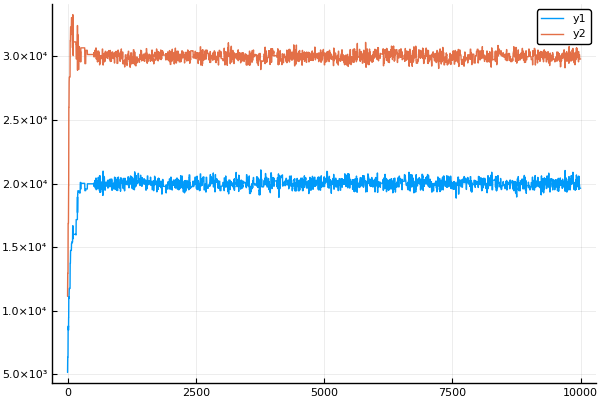

In [24]:
plot(vResults[1]["outputs"])

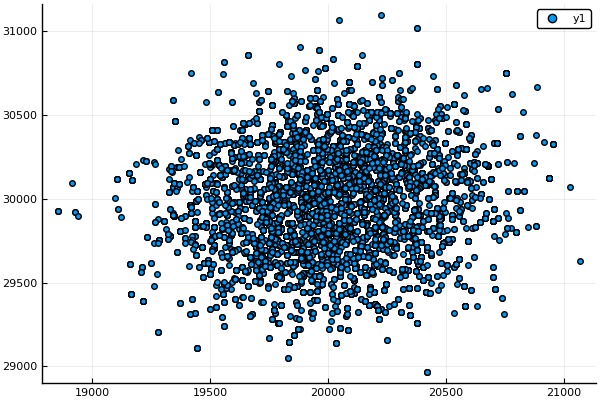

In [25]:
scatter(vResults[1]["outputs"][1000:end, 1], vResults[1]["outputs"][1000:end, 2])

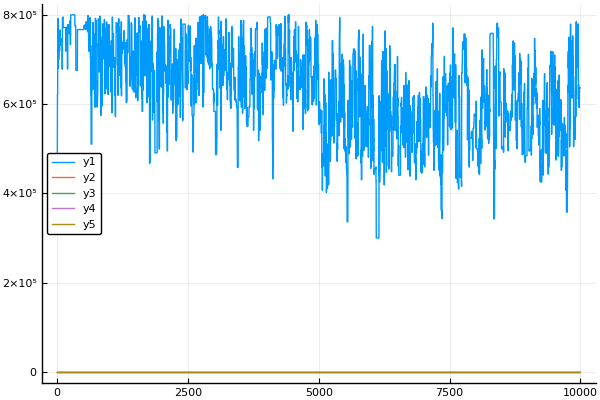

In [26]:
plot(vResults[1]["inputs"])

### Non-uniform priors

In [27]:
function f_sample_solve_nonuniform_growth_factor(num_samples, population_sample, times_solve,
        tspan, f_solve, f_deriv, prior_params, initial)
    n_params = size(prior_params)[1]
    samples = zeros((num_samples, n_params))
    vL = [2, 10]
    for i = 1:n_params
        samples[:, i] = rand(Normal(prior_params[i, 1], prior_params[i, 2]), num_samples)
    end
    mOutputs = zeros((num_samples, length(population_sample)))
    for i in 1:num_samples
        for j = 1:length(population_sample)
            sol = f_solve(f_deriv, initial, tspan, vcat(samples[i, :], [vL[j]]));
            mOutputs[i, j] = sol(times_solve[j], idxs=population_sample[j])
        end
    end
    return mOutputs
end

f_sample_solve_nonuniform_growth_factor (generic function with 1 method)

In [28]:
# number of independent samples to take from bounds
ncontourvolsteps = 100000

# bounds of parameters (uniform prior within bounds assumed)
prior_params = [[5 * 10^5 10^5]; [0.3 0.1]; [0.5 0.1]; [3 1]; [0.02 0.005]];

tspan = (0.0, 20.0)
initial_states = [0.0; 0.0];
populations_observed = [2, 2]
times_observed = [10, 10]


mOutputs = @time f_sample_solve_nonuniform_growth_factor(ncontourvolsteps, populations_observed, times_observed,
    tspan, f_solve, deriv_growth_factor, prior_params, initial_states);

@time f_estimate_kdevine(mOutputs);

 41.805706 seconds (176.99 M allocations: 13.223 GiB, 7.95% gc time)
985.269490 seconds (112 allocations: 3.453 KiB)


In [29]:
function log_prior(prior_params, vX)
    log_prior1 = 0.0
    for j = 1:length(vX)
        log_prior1 += logpdf(Normal(prior_params[j, 1], prior_params[j, 2]), vX[j])
    end
    return log_prior1
end
function f_mcmc_nonuniform_growth_factor(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, prior_params, initial_inputs, initial)
    mInputs = zeros((num_samples, size(prior_params)[1]))
    mOutputs = zeros((num_samples, length(population_sample)))
    vOutputs_temp = zeros(length(population_sample))
    vLogPDF = zeros(num_samples)
    vContour = zeros(num_samples)
    vL = [2, 10]
    # initial points
    mInputs[1, :] = initial_inputs
    for j = 1:length(population_sample)
        sol = f_solve(f_deriv, initial, tspan, vcat(mInputs[1, :], [vL[j]]));
        mOutputs[1, j] = sol(times_solve[j], idxs=population_sample[j])
    end
    log_pdf_current = target_fn(mOutputs[1, :])
    log_contour_current = log(f_dkdevine(mOutputs[1, :]))
    # MCMC
    log_a = 0.0
    sigma = Matrix(Diagonal(sigma.^2))
    mu = initial_inputs
    for i = 2:num_samples
        if i <= (100 * length(initial_inputs))
            vProposed = rand(MvNormal(mInputs[i - 1, :], sigma), 1)
            for j = 1:length(population_sample)
                sol = f_solve(f_deriv, initial, tspan, vcat(vProposed, [vL[j]]));
                vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
            end
            log_prior_proposed = log_prior(prior_params, vProposed)
            log_prior_current = log_prior(prior_params, mInputs[i - 1, :])
            log_pdf_proposed = target_fn(vOutputs_temp)
            log_contour_proposed = log(f_dkdevine(vOutputs_temp))
            log_r = ((log_pdf_proposed + log_contour_current + log_prior_proposed) -
                     (log_pdf_current + log_contour_proposed + log_prior_current))
            if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -30)
                mInputs[i, :] = vProposed
                mOutputs[i, :] = vOutputs_temp
                log_pdf_current = log_pdf_proposed
                log_contour_current = log_contour_proposed
                accepted = 1.0
            else
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
        else
            s = i - (100 * length(initial_inputs))
            gamma = (s + 1)^(-0.6)
            vProposed = rand(MvNormal(mInputs[i - 1, :], Matrix(Hermitian(sigma)) * exp(log_a)), 1)
            for j = 1:length(population_sample)
                sol = f_solve(f_deriv, initial, tspan, vcat(vProposed, [vL[j]]));
                vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
            end
            log_prior_proposed = log_prior(prior_params, vProposed)
            log_prior_current = log_prior(prior_params, mInputs[i - 1, :])
            log_pdf_proposed = target_fn(vOutputs_temp)
            log_contour_proposed = log(f_dkdevine(vOutputs_temp))
            log_r = ((log_pdf_proposed + log_contour_current + log_prior_proposed) -
                     (log_pdf_current + log_contour_proposed + log_prior_current))
            if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -30)
                mInputs[i, :] = vProposed
                mOutputs[i, :] = vOutputs_temp
                log_pdf_current = log_pdf_proposed
                log_contour_current = log_contour_proposed
                accepted = 1.0
            else
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
            sigma = (1 - gamma) * sigma + gamma * (mInputs[i, :] - mu) * (mInputs[i, :] - mu)'
            mu = (1 - gamma) * mu + gamma * mInputs[i, :]
            log_a += gamma * (accepted - 0.25)
        end
    end
    return Dict("inputs" => mInputs, "outputs" => mOutputs, "log_pdf" => vLogPDF, "contour_volume" => vContour)
end

function f_mcmc_nonuniform_growth_factor_multiple(nchains, num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, prior_params, initial_inputs, initial)
    vResults = []
    for i = 1:nchains
         push!(vResults, f_mcmc_nonuniform_growth_factor(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, prior_params, initial_inputs, initial))
    end
    return vResults
end

f_mcmc_nonuniform_growth_factor_multiple (generic function with 1 method)

In [30]:
# number of chains (not run in parallel due to RCall)
nchains = 4
# number of MCMC steps (adapting after 100 * length(initial_parametesr))
nsamples = 10000
# MCMC initial (before adaptation) step sizes
sigma = [1.0 * 10^5, 0.05, 0.025, 0.5, 0.0005];
# initial parameters
initial_parameters = [4.0 * 10^5; 0.25; 1.0; 10; 0.01]
dist = MvNormal([2.0 * 10^4, 3.0 * 10^4], [[100000.0 0.0]; [0.0 100000.0]])
vResults = @time f_mcmc_nonuniform_growth_factor_multiple(nchains, nsamples, x -> logpdf(dist, x), dkdevine,
                    sigma, populations_observed, times_observed, tspan,
                    f_solve, deriv_growth_factor,
                    prior_params, initial_parameters, initial_states);
output_samples(vResults, "growth_factor_nonuniform")

1938.183776 seconds (76.57 M allocations: 5.553 GiB, 0.07% gc time)


In [31]:
f_rhat(vResults)

1×5 Array{Float64,2}:
 1.00353  1.00556  1.00866  1.00137  1.00924

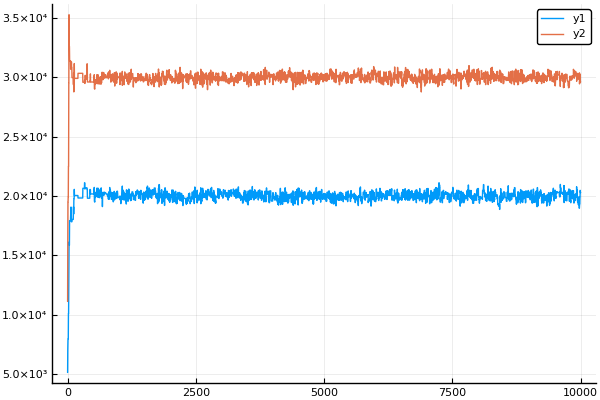

In [32]:
plot(vResults[1]["outputs"])